# Demonstrate the reproducibility of Zelinka and al. (2023) results


--- 

## What this notebook holds :

---

### Description of the notebook

This notebook aims at reproducing the results shown in *Zelinka and al.* (2023).
More details can be found in *sw_analysis_aprp_arctic.ipynb*.

### Article we are reproducting

Zelinka, M. D., Smith, C. J., Qin, Y., and Taylor, K. E.: Comparison of methods to estimate aerosol effective radiative forcings in climate models, Atmos. Chem. Phys., 23, 8879–8898, https://doi.org/10.5194/acp-23-8879-2023, 2023.

### APRP method's reference

Taylor, K. E., M. Crucifix, P. Braconnot, C. D. Hewitt, C. Doutriaux, A. J. Broccoli, J. F. B. Mitchell, and M. J. Webb, 2007: Estimating Shortwave Radiative Forcing and Response in Climate Models. J. Climate, 20, 2530–2543, https://doi.org/10.1175/JCLI4143.1. 

### APRP module used for our analysis' reference

https://doi.org/10.5281/zenodo.5514141

### Author

Giboni Lucas, 1st year PhD Candidate at IGE (CNRS), Grenoble.

https://github.com/gibonil/gibonil

### License

Feel free to share, use and improve the following code according to the provided license on the repository.

---

# Initialisation

---

## Importations

We import the needed libraries

In [ ]:
# ================ IMPORTATIONS ================ #

### LOAD AND NAVIGATE THROUGH THE DATA ###

import os  # to get access to commands related to path setting and creation of directories

### DATA OBJECTS AND ASSOCIATED COMPUTATION ###

import numpy as np  # to handle numpy arrays and the associated tools

import xarray as xr  # to manage the data

import xcdat as xc  # to handle climate model outputs with xarray

### REPRESENTING DATA ###

import matplotlib.pyplot as plt  # to handle plotting routines

import cartopy.crs as ccrs  # to handle map projections

### HOMEMADE LIBRARIES ###

## Load the climatology dictionary ##

from utilities.get_cmip6_data.store_data.dict_netcdf_transform import (
    netcdf_to_dict, # to load the climatology dictionary
)  

## Handle the climatology dictionary ##

from utilities.tools_for_analysis.handle_entries.extract_entries_names import (
    get_entries_only_from_clim_dict, # to add extract the entries' names
)

## Retrieve all the entries' names without the corresponding experiment ##

from utilities.get_cmip6_data.prepare_data.extract_climatologies import (
    add_one_variable_to_dataset, # to add one variable to the full dataset
)

## Generate a common grid on which we will regrid all CMIP6 outputs ##

from utilities.tools_for_analysis.regridding.regridding_methods import(
    generate_the_common_coarse_grid, # to create the common coarse grid 
    regridding_a_dictionary, # to regrid the aprp dictionary
)

## Extract only one variant's model output ##

from utilities.tools_for_analysis.handle_entries.extract_one_variant_per_model import (
    extract_only_one_variant_keys_list, # generates the keys' list with only one variant per source id
)

### APRP LIBRARY ###

from utilities.aprp.code.aprp import(
    APRP, # APRP method
)

### Define the paths for saving and loading data

In this part, the user needs to define the paths at which will be downloaded the data and saved the climatologies if necessary. They also need to define the path to the table associating the monthly climatologies netcdf files with their respective key in the climatologies' dictionary to be loaded. These paths are the absolute paths from the home directory.

If *get_cmip6_data.ipynb* notebook was run before, then only the path to the *key_paths_table.pkl* file is relevant here.

In [2]:
# ================ DEFINE THE FOLDERS WHERE IS STORED THE DATA ================ #

### DEFINE THE HOME DIRECTORY ###

## Home directory ##

homedir_path = os.path.expanduser("~")

### DEFINE WHERE TO DOWNLOAD THE RAW DATA ###

## Parent directory of the download folder ##

parent_path_download = homedir_path + "/certainty-data"

## Name of the download folder ##

download_folder_name = "CMIP6-DATA"

### DEFINE WHERE TO SAVE THE CLIMATOLOGIES ###

## Path of the save directory ##

parent_path_save_clim = (
    homedir_path + "/certainty-data/" + download_folder_name + "/climatologies"
)

### DEFINE WHERE TO LOOK FOR THE TABLE OF THE CLIMATOLOGIES' PATHS ###

table_path = parent_path_save_clim + "/table" + "/key_paths_table.pkl"

## Load the CMIP6 climatology

We load the CMIP6 climatology. We first check the existence of the *key_paths_table.pkl* file that indicate that the *get_cmip6_data.ipynb* notebook was successfully run. Otherwise, we launch the full routine to download the raw data and generate the climatologies. 

**This full routine lasts about 2 hours if no download was done before.**

Sometimes the data cannot be found for the downloading phase even though the entry was found in the search phase... The user will need to relaunch the code as it is an error linked to the connection to the servers.

In [3]:
# ================ LOAD THE MONTHLY CLIMATOLOGIES ================ #

### CHECK IF THE CLIMATOLOGIES WERE GENERATED BEFORE ###

if os.path.lexists(path = table_path) :

    ## The table exists we can therefore load the dictionary of the climatologies ## 

    print("The monthly climatologies were generated and can be retrieved.")

    data_cmip6_clim = netcdf_to_dict(parent_path_for_save = parent_path_save_clim)

else :

    ## The table does not exist : we need to download the data and prepare it ##

    print("No key_paths_table.pkl at the given path.\n" \
    "We download the data and create the monthly climatologies dictionary.")

    # We import the necessary submodule #

    from utilities.get_cmip6_data.prepare_data.extract_climatologies import (
    create_climatology_dict,  # to create the climatology dictionary and save it
    )

    ## Create the climatologies dictionary ##

    create_climatology_dict(
        data_path = parent_path_download,
        data_folder_name = download_folder_name,
        parent_path_for_save = parent_path_save_clim,
        selected_case = "ZELINKA-SW",
        do_we_clear = True,
        verbose = False,
    )

    ## Load it ##

    data_cmip6_clim = netcdf_to_dict(parent_path_for_save = parent_path_save_clim)

The monthly climatologies were generated and can be retrieved.


## Apply the Approximate Partial Radiative Perturbation computation to our dictionary

### Generate the APRP dictionary

Before applying the APRP function we have to be able to call both the **control** and **aer** xarray datasets for a given entry. This is why we start by generating the list of the dictionary keys without the experiments.

In [4]:
# ================ GET THE KEYS WITHOUT THE EXPERIMENT REFERENCE ================ #

### GENERATE THE KEYS WITHOUT THE EXPERIMENT ###

## Copy the list of the keys of the clim dictionary ##

clim_keys = list(data_cmip6_clim.keys())

## Generate the unique list of keys without the reference to the experiments ##

clim_keys_without_exp = [
    get_entries_only_from_clim_dict(key_with_exp) for key_with_exp in clim_keys
]

We apply the APRP method.

In [5]:
dict_aprp = {}

for key in clim_keys_without_exp:

    key_control = key + ".piClim-control"

    key_aer = key + ".piClim-aer"

    data_cmip6_clim[key_control].load()

    data_cmip6_clim[key_aer].load()

    output = APRP(data_cmip6_clim[key_control], data_cmip6_clim[key_aer])

    dict_aprp[key] = output

---

## Regrid the dictionary entries on a common coarser grid

---

### Creating a common coarser grid for all CMIP6 outputs

In order to be able to compare the different results, we wish to project them on a common map. This map needs to be coarser than all the natives grid in order to not generate false signals but still needs to be close enough to their original resolution. The solution that was found here is to generate the coarsest grid steps for latitude and longitude from the ensemble and generate a regular grid from them.

In [6]:
common_coarse_grid = generate_the_common_coarse_grid(dict_aprp)

### Regrid the entries

We now proceed to the regridding of the full dictionary.

In [7]:
### FIELDS THAT WE REGRID ###

fields_to_be_regridded = [
    'cld',
    'sfc_alb',
    'sfc_alb_clr',
    'sfc_alb_oc',
    'noncld',
    'noncld_scat',
    'noncld_abs',
    'cld_amt',
    'cld_scat',
    'cld_abs'
    ]

### REGRIDDING ROUTINE ###

dict_aprp_regridded = regridding_a_dictionary(
    fields_to_be_regridded = fields_to_be_regridded,
    output_grid = common_coarse_grid,
    dictionary_to_be_regridded = dict_aprp
)

Initialize with one variable...



Regridding all the variables...: 100%|██████████| 9/9 [01:07<00:00,  7.48s/it]


Adding areacella...

Done !


---

## Time average of the monthly climatologies 

---

In order to display one common maps per varaible we average the twelve monthly climatology maps into one.

In [40]:
### COMPUTE TIME AVERAGE ###

## Generate a dictionary of the regridded APRP maps averaged over time ##

dict_aprp_time_avg = {
    key: dict_aprp_regridded[key]
    .groupby(dict_aprp[key].time.dt.month) # we already have monthly climatologies but this way we simplify the time coordinate into into a "month" coordinate
    .mean().mean("month") # average over time
    for key in list(dict_aprp.keys())
}

---

## Spatial average of the time averaged map

---

Now that we have achieved a time average, we wish to average to resulting map to generate spatial averages of the different variables of the APRP method and write them into a table.

---

## Reproduce the table of Zelinka and al. (2023)

---

This part aims at reproducing the table found in the article for the shortwave. Here is a screenshot of the table :

<img src="/Users/lgiboni/Doctorat/code/CMIP6-Arctic-Aerosol-Analysis/img/zelinka-2023-table-screenshot.png">

In [9]:
def adapt_for_spatial_avgd(DS : xr.Dataset) -> xr.Dataset :
    DS.lat.attrs["axis"] = "Y"
    DS.lon.attrs["axis"] = "X"
    DS = DS.bounds.add_missing_bounds()

    return DS

In [10]:
dict_aprp_time_avg = {
    key: adapt_for_spatial_avgd(dict_aprp_time_avg[key])
    for key in dict_aprp_time_avg.keys()
}

In [11]:
keys_aprp = list(dict_aprp.keys())

key_00 = keys_aprp[0]

dict_aprp_time_avg[key_00].spatial.average("noncld_scat", axis=["X", "Y"])["noncld_scat"].values



array(-0.83929746)

In [12]:
def spatial_average_given_field(field : str, ds):

    spatial_avg = ds.spatial.average(field, axis=["X", "Y"])[field].values

    return np.round(spatial_avg, 2)

In [13]:
def compute_needed_spatial_avg_for_tables(key : str, ds : xr.Dataset):

    noncld_scat = spatial_average_given_field(field = "noncld_scat", ds = ds)

    noncld_abs = spatial_average_given_field(field = "noncld_abs", ds = ds)

    sum_ari = noncld_scat + noncld_abs

    dict_ari = {key :
                {
        'scat' : noncld_scat,
        'abs' : noncld_abs,
        'sum' : sum_ari,
                }
    }
    cld_scat = spatial_average_given_field(field = "cld_scat", ds = ds)

    cld_abs = spatial_average_given_field(field = "cld_abs", ds = ds)

    cld_amt = spatial_average_given_field(field = "cld_amt", ds = ds)

    sum_aci = cld_scat + cld_abs + cld_amt

    dict_aci = { 
        key : {
        'scat' : cld_scat,
        'abs' : cld_abs,
        'cld_amt' : cld_amt,
        'sum' : sum_aci,
        }
    }

    
    sum_aci_ari = sum_aci + sum_ari

    dict_sum_aci_ari = {
        key : {
            "ACI + ARI " : sum_aci_ari
        }
    }
    return dict_ari, dict_aci, dict_sum_aci_ari

In [14]:
dict_ari_0, dict_aci_0, dict_sum_aci_ari = compute_needed_spatial_avg_for_tables(key = key_00, ds = dict_aprp_time_avg[key_00])

In [15]:
import pandas as pd

In [16]:
# initialize 

df1 = pd.DataFrame.from_dict(dict_ari_0)

df2 = pd.DataFrame.from_dict(dict_aci_0)

df3 = pd.DataFrame.from_dict(dict_sum_aci_ari)

dict1 = {'ARI' : df1, 'ACI' : df2, '' : df3}

df = pd.concat(dict1).T



In [17]:
key_00 = keys_aprp[0]

dict_ari, dict_aci, dict_sum_aci_ari = compute_needed_spatial_avg_for_tables(key = key, ds = dict_aprp_time_avg[key])

df1 = pd.DataFrame.from_dict(dict_ari)

df2 = pd.DataFrame.from_dict(dict_aci)

df3 = pd.DataFrame.from_dict(dict_sum_aci_ari)

dict_to_be_dfd = {'ARI' : df1, 'ACI' : df2, '' : df3}

main_df = pd.concat(dict_to_be_dfd).T

for key in keys_aprp :

    dict_ari, dict_aci, dict_sum_aci_ari = compute_needed_spatial_avg_for_tables(key = key, ds = dict_aprp_time_avg[key])

    df1 = pd.DataFrame.from_dict(dict_ari)

    df2 = pd.DataFrame.from_dict(dict_aci)

    df3 = pd.DataFrame.from_dict(dict_sum_aci_ari)

    dict_to_be_dfd = {'ARI' : df1, 'ACI' : df2, '' : df3}

    df = pd.concat(dict_to_be_dfd).T

    main_df = pd.concat([main_df, df])

In [18]:
main_df = main_df.sort_index()

mean = main_df.mean(skipna = True)

std = main_df.std(skipna = True)



In [19]:
main_df

ARI               ACI                      \
                               scat   abs   sum  scat   abs cld_amt   sum   
ACCESS-CM2.r1i1p1f1.gn        -0.84  0.42 -0.42 -0.82 -0.01   -0.13 -0.96   
ACCESS-ESM1-5.r1i1p1f1.gn     -0.44  0.28 -0.16 -1.04  0.05   -0.13 -1.12   
BCC-ESM1.r1i1p1f1.gn          -1.13  0.30 -0.83 -0.62 -0.09   -0.09 -0.80   
CESM2.r1i1p1f1.gn             -0.26  0.50  0.24 -1.80  0.04   -0.00 -1.76   
CNRM-CM6-1.r1i1p1f2.gr        -0.65  0.29 -0.36 -0.83 -0.07    0.05 -0.85   
CNRM-ESM2-1.r1i1p1f2.gr       -0.44  0.25 -0.19 -0.54 -0.06   -0.03 -0.63   
CanESM5.r1i1p2f1.gn           -0.64  0.76  0.12 -0.92  0.08   -0.14 -0.98   
GFDL-CM4.r1i1p1f1.gr1         -0.68  0.59 -0.09 -0.55  0.00   -0.09 -0.64   
GISS-E2-1-G.r1i1p1f1.gn       -0.94  0.27 -0.67  0.07  0.02   -0.95 -0.86   
GISS-E2-1-G.r1i1p1f2.gn       -0.88  0.20 -0.68  0.08  0.03   -0.84 -0.73   
GISS-E2-1-G.r1i1p3f1.gn       -0.99  0.24 -0.75 -0.23 -0.01   -0.07 -0.31   
HadGEM3-GC31-LL.r1i1p1f3.gn   -0.83  0.42 -0.41 -0.78 -0.01   -0.07 -0.86   
IPSL-CM6A-LR-INCA.r1i1p1f1.gr -0.69  0.20 -0.49 -0.29 -0.01    0.03 -0.27   
IPSL-CM6A-LR.r1i1p1f1.gr      -0.63  0.23 -0.40 -0.28 -0.01    0.09 -0.20   
IPSL-CM6A-LR.r2i1p1f1.gr      -0.63  0.23 -0.40 -0.29 -0.01    0.01 -0.29   
IPSL-CM6A-LR.r3i1p1f1.gr      -0.63  0.24 -0.39 -0.25 -0.02    0.11 -0.16   
IPSL-CM6A-LR.r4i1p1f1.gr      -0.63  0.23 -0.40 -0.29 -0.01    0.02 -0.28   
MIROC6.r11i1p1f1.gn           -0.47  0.12 -0.35 -1.13 -0.09   -0.03 -1.25   
MIROC6.r1i1p1f1.gn            -0.48  0.13 -0.35 -1.13 -0.08   -0.01 -1.22   
MPI-ESM-1-2-HAM.r1i1p1f1.gn   -0.26  0.27  0.01 -1.35  0.03   -0.24 -1.56   
MRI-ESM2-0.r1i1p1f1.gn        -0.76  0.27 -0.49 -1.73 -0.12   -0.38 -2.23   
NorESM2-LM.r1i1p1f1.gn        -0.43  0.30 -0.13 -1.16 -0.00   -0.10 -1.26   
NorESM2-LM.r1i1p2f1.gn        -0.45  0.31 -0.14 -1.32  0.01   -0.19 -1.50   
NorESM2-MM.r1i1p1f1.gn        -0.42  0.32 -0.10 -1.19  0.02   -0.17 -1.34   
UKESM1-0-LL.r1i1p1f4.gn       -0.76  0.48 -0.28 -0.85 -0.01   -0.10 -0.96   
UKESM1-0-LL.r1i1p1f4.gn       -0.76  0.48 -0.28 -0.85 -0.01   -0.10 -0.96   

                                          
                              ACI + ARI   
ACCESS-CM2.r1i1p1f1.gn             -1.38  
ACCESS-ESM1-5.r1i1p1f1.gn          -1.28  
BCC-ESM1.r1i1p1f1.gn               -1.63  
CESM2.r1i1p1f1.gn                  -1.52  
CNRM-CM6-1.r1i1p1f2.gr             -1.21  
CNRM-ESM2-1.r1i1p1f2.gr            -0.82  
CanESM5.r1i1p2f1.gn                -0.86  
GFDL-CM4.r1i1p1f1.gr1              -0.73  
GISS-E2-1-G.r1i1p1f1.gn            -1.53  
GISS-E2-1-G.r1i1p1f2.gn            -1.41  
GISS-E2-1-G.r1i1p3f1.gn            -1.06  
HadGEM3-GC31-LL.r1i1p1f3.gn        -1.27  
IPSL-CM6A-LR-INCA.r1i1p1f1.gr      -0.76  
IPSL-CM6A-LR.r1i1p1f1.gr           -0.60  
IPSL-CM6A-LR.r2i1p1f1.gr           -0.69  
IPSL-CM6A-LR.r3i1p1f1.gr           -0.55  
IPSL-CM6A-LR.r4i1p1f1.gr           -0.68  
MIROC6.r11i1p1f1.gn                -1.60  
MIROC6.r1i1p1f1.gn                 -1.57  
MPI-ESM-1-2-HAM.r1i1p1f1.gn        -1.55  
MRI-ESM2-0.r1i1p1f1.gn             -2.72  
NorESM2-LM.r1i1p1f1.gn             -1.39  
NorESM2-LM.r1i1p2f1.gn             -1.64  
NorESM2-MM.r1i1p1f1.gn             -1.44  
UKESM1-0-LL.r1i1p1f4.gn            -1.24  
UKESM1-0-LL.r1i1p1f4.gn            -1.24

In [20]:
mean.round(2)

ARI  scat         -0.64
     abs           0.32
     sum          -0.32
ACI  scat         -0.77
     abs          -0.01
     cld_amt      -0.14
     sum          -0.92
     ACI + ARI    -1.25
dtype: float64

In [21]:
std.round(2)

ARI  scat          0.22
     abs           0.15
     sum           0.26
ACI  scat          0.50
     abs           0.05
     cld_amt       0.25
     sum           0.51
     ACI + ARI     0.47
dtype: float64

--- 

## Reproduce Zelinka's maps

---

This part aims at reproducing the maps found in the article for the shortwave. Here is a screenshot of these maps :

<img src="/Users/lgiboni/Doctorat/code/CMIP6-Arctic-Aerosol-Analysis/img/zelinkas-map.png">

In [22]:
def create_list_of_spatial_averaged_variables_for_given_entry(dataset : xr.Dataset) -> list[float]:

    plot_list_avg = [
    (dataset.spatial.average("cld", axis=["X", "Y"])["cld"] + dataset.spatial.average("noncld", axis=["X", "Y"])["noncld"]).values, # SW ERF ARI + ACI
    (dataset.spatial.average("noncld", axis=["X", "Y"])["noncld"]).values, # SW ERF ARI
    (dataset.spatial.average("cld", axis=["X", "Y"])["cld"]).values, # SW ERF ACI
    (dataset.spatial.average("sfc_alb", axis=["X", "Y"])["sfc_alb"]).values, # DELTA ALBED SURF
    ]

    return plot_list_avg


used to make zelinka's plots

In [23]:
reduced_list = [
'CNRM-CM6-1.r1i1p1f2.gr',
'CNRM-ESM2-1.r1i1p1f2.gr',
'CanESM5.r1i1p2f1.gn',
'GFDL-CM4.r1i1p1f1.gr1',
'MPI-ESM-1-2-HAM.r1i1p1f1.gn',
'MRI-ESM2-0.r1i1p1f1.gn',
'NorESM2-LM.r1i1p1f1.gn',
'NorESM2-LM.r1i1p2f1.gn',
'NorESM2-MM.r1i1p1f1.gn',
'UKESM1-0-LL.r1i1p1f4.gn'
 ]

In [24]:
"""keys_aprp = list(dict_aprp.keys())

reduced_list = extract_only_one_variant_keys_list(keys_aprp)"""

'keys_aprp = list(dict_aprp.keys())\n\nreduced_list = extract_only_one_variant_keys_list(keys_aprp)'

In [25]:
dict_aprp_reduced = {
    key : dict_aprp[key]
    for key in reduced_list
}

In [26]:
# make the average list

dict_aprp_before_regridding = {
    key: dict_aprp_reduced[key]
    .groupby(dict_aprp_reduced[key].time.dt.month)
    .mean().mean('month')
    for key in dict_aprp_reduced.keys()
}

In [27]:
# needed for the concat function to work

dict_aprp_regridded_time_avg = {
    key: dict_aprp_regridded[key]
    .groupby(dict_aprp_regridded[key].time.dt.month)
    .mean().mean("month")
    for key in dict_aprp_reduced.keys()
}

In [28]:
dict_aprp_regridded_time_avg= {
    key: adapt_for_spatial_avgd(dict_aprp_regridded_time_avg[key])
    for key in dict_aprp_reduced.keys()
}

In [29]:


list_avgd_variables_for_all_entries = [
    create_list_of_spatial_averaged_variables_for_given_entry(dict_aprp_regridded_time_avg[key])
    for key in dict_aprp_reduced.keys()
]

# adding gfdl esm4 (missing) from zelinka's results
list_avgd_variables_for_all_entries.append([-0.55, +0.09, -0.64, np.nan])

talk to louis about this ???

diff on ACI which leads to an "error"

In [30]:
for i in range(len(list_avgd_variables_for_all_entries)):

    print(np.round(list_avgd_variables_for_all_entries[i], 2))

[-1.21 -0.36 -0.86 -0.07]
[-0.82 -0.19 -0.63 -0.01]
[-0.86  0.12 -0.98  0.03]
[-0.73 -0.09 -0.64 -0.07]
[-1.54  0.01 -1.55 -0.02]
[-2.71 -0.48 -2.23 -0.01]
[-1.39 -0.13 -1.27 -0.02]
[-1.64 -0.14 -1.5  -0.03]
[-1.44 -0.1  -1.34 -0.02]
[-1.23 -0.28 -0.95 -0.05]
[-0.55  0.09 -0.64   nan]


In [31]:
res_to_show = np.round(np.nanmean(list_avgd_variables_for_all_entries, axis = 0), 2)

In [32]:
res_to_show

array([-1.28, -0.14, -1.14, -0.03])

In [33]:
# let's make the entry average

ensemble_aprp_avg = xr.concat(dict_aprp_regridded_time_avg.values(), "entry").mean(
    dim="entry"
)



In [34]:
# needed for the concat function to work

dict_aprp_regridded_time_avg = {
    key: dict_aprp_regridded[key]
    .groupby(dict_aprp_regridded[key].time.dt.month)
    .mean()
    for key in reduced_list
}


In [35]:
dict_aprp_regridded[key]

<xarray.Dataset> Size: 4MB
Dimensions:      (time: 12, lat: 64, lon: 128, bnds: 2)
Coordinates:
  * time         (time) object 96B 0001-01-01 00:00:00 ... 0001-12-01 00:00:00
  * lat          (lat) float64 512B -88.59 -85.78 -82.97 ... 82.97 85.78 88.59
  * lon          (lon) float64 1kB 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
Dimensions without coordinates: bnds
Data variables: (12/14)
    cld          (time, lat, lon) float32 393kB 0.2218 0.2139 0.1958 ... 0.0 0.0
    lon_bnds     (lon, bnds) float64 2kB -1.406 1.406 1.406 ... 355.8 358.6
    lat_bnds     (lat, bnds) float64 1kB -90.0 -87.19 -87.19 ... 87.19 90.0
    time_bnds    (time, bnds) object 192B 0001-01-01 00:00:00 ... 0002-01-01 ...
    sfc_alb      (time, lat, lon) float32 393kB 0.1854 0.1909 0.1984 ... 0.0 0.0
    sfc_alb_clr  (time, lat, lon) float32 393kB 0.06062 0.06328 ... 0.0 0.0
    ...           ...
    noncld_scat  (time, lat, lon) float32 393kB -0.1195 -0.1195 ... 0.0 0.0
    noncld_abs   (time, lat, lon) float32 393kB -0.491 -0.4932 ... 0.0 0.0
    cld_amt      (time, lat, lon) float32 393kB -0.02017 -0.02389 ... 0.0 0.0
    cld_scat     (time, lat, lon) float32 393kB 0.3312 0.3304 0.3198 ... 0.0 0.0
    cld_abs      (time, lat, lon) float32 393kB -0.08914 -0.09263 ... 0.0 0.0
    areacella    (lat, lon) float64 66kB 2.4e+09 2.4e+09 ... 2.4e+09 2.4e+09

In [36]:
import matplotlib.pyplot as plt # used for makings nice plots

import matplotlib.dates as mdates # used to show months in a plot legend

import matplotlib.colors as colors # used to linearly interpolate uneven colorbars

import matplotlib.path as mpath # used to handle the polar circle

from cartopy.util import add_cyclic_point # to have nice contours plot on the earth's map


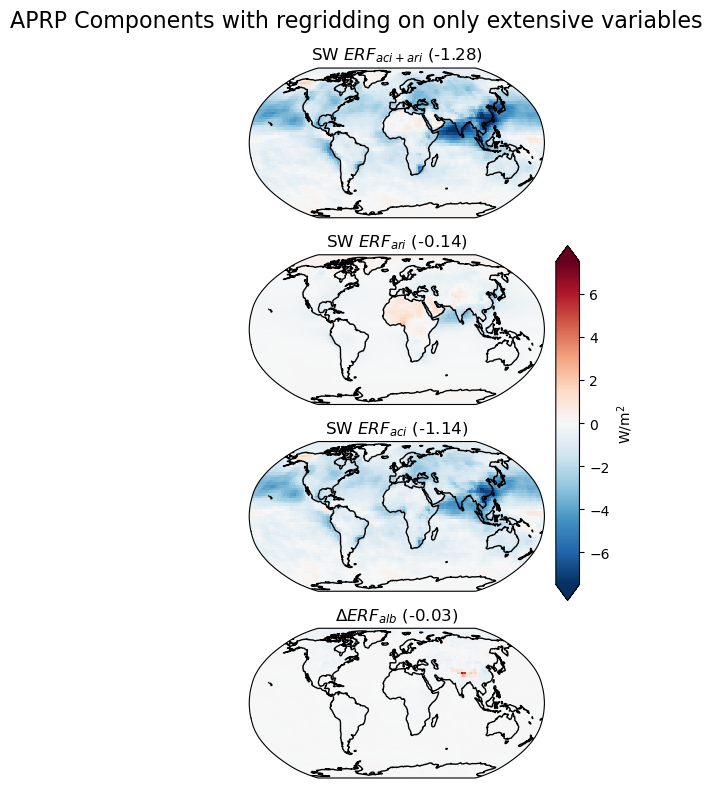

In [37]:
output = ensemble_aprp_avg

fig = plt.figure(figsize = (6,8))
plt.suptitle("APRP Components with regridding on only extensive variables", fontsize=16)
axes = fig.subplots(nrows= 4, ncols = 1, subplot_kw={"projection": ccrs.Robinson()})
cnt = -1

avgmap = output


plot_list_avg = res_to_show

plot_list_map = [
    (avgmap["cld"] + avgmap["noncld"]), # SW ERF ARI + ACI
    (avgmap["noncld"]), # SW ERF ARI
    (avgmap["cld"]), # SW ERF ACI
    (avgmap["sfc_alb"]), # DELTA ALBED SURF
]

list_titles = [
        "SW $ERF_{aci + ari}$",
        "SW $ERF_{ari}$",
        "SW $ERF_{aci}$",
        "$\\Delta ERF_{alb}$"
]
for row in range(4):
        
        cnt += 1

        avg = plot_list_avg[cnt]

        pl = plot_list_map[cnt].plot(
            ax=axes[row],
            transform=ccrs.PlateCarree(),
            vmin=-7.5,
            vmax=7.5,
            cmap="RdBu_r",
            add_colorbar=False,
        )
        axes[row].set_title(list_titles[cnt] + " (" + str(np.round(avg,3)) + ")")

        axes[row].coastlines()

plt.tight_layout()

fig.colorbar(
    pl, ax=axes.ravel().tolist(), pad=0.02, shrink=0.5, aspect=15, label="W/m$^2$", extend='both'
)
